In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense,Add, Dropout, Resizing,Rescaling,InputLayer,Flatten,LayerNormalization, MultiHeadAttention
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers,Model
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix
from tensorflow.keras.regularizers import L2
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomFlip, RandomContrast

from tensorflow.keras.preprocessing.image import load_img
from functools import partial
import seaborn as sns
from sklearn.model_selection   import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [4]:
learning_rate = 0.001
class_name=['glioma','meningioma','notumor','pituitary']
weight_decay = 0.0001
num_classes=4
batch_size =32
num_epochs = 100
image_size = 72
patch_size = 16
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
Num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
num_layers = 15
Hidden_size=64
mlp_head_units = 1024

In [5]:
train_data='/content/drive/MyDrive/Brain Tumor Segmentation Dataset/image'


In [6]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_data,
    labels='inferred',
    label_mode='categorical',
    class_names=class_name,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(image_size,image_size),
    shuffle=True,
    seed=99,
    validation_split=0.2,
    subset='training',
)
val_dataset = tf.keras.utils.image_dataset_from_directory(
    train_data,
    labels='inferred',
    label_mode='categorical',
    class_names=class_name,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(image_size,image_size),
    shuffle=True,
    seed=99,
    validation_split=0.2,  # Use 20% of the data for validation
    subset='validation',
)


Found 4267 files belonging to 4 classes.
Using 3414 files for training.
Found 4267 files belonging to 4 classes.
Using 853 files for validation.


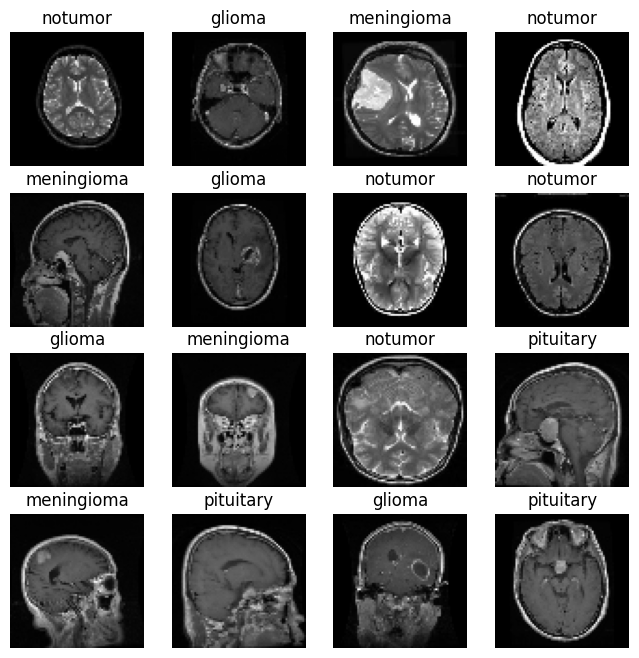

In [7]:
plt.figure(figsize=(8, 8))
for images, labels in train_dataset.take(10):
    for i in range(min(16, len(images))):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i] / 255., cmap='gray')
        plt.title(class_name[tf.argmax(labels[i]).numpy()])
        plt.axis("off")

plt.show()


In [8]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor=(-0.25, 0.2501)),
   RandomFlip("horizontal_and_vertical",seed=42),  # Specify a seed for reproducibility
])

In [9]:
def process_data(image, label):
    augmented_image=augment_layers(image)
    resized_image = tf.image.resize(augmented_image, size=(image_size, image_size))
    return resized_image, label

training_dataset = (
    train_dataset.
    shuffle(1000)
    .map(partial(process_data),num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [10]:
vali_dataset=(
   val_dataset.shuffle(1000)
    .prefetch(tf.data.AUTOTUNE)
)

In [11]:
input_tensor = next(iter(training_dataset))[0]

In [12]:
patche=tf.image.extract_patches(images=input_tensor,
                               sizes=[1,patch_size,patch_size,1],
                                strides=[1,patch_size,patch_size,1],
                                rates=[1,1,1,1],
                                 padding='VALID')


In [13]:
class PatchEncoder(layers.Layer):
    def __init__(self, patch_size,Hidden_size):
        super(PatchEncoder, self).__init__(name='patch_encoder')
        self.linear_projection=Dense(Hidden_size)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=Hidden_size
        )

        self.num_patches=num_patches

    def call(self, image):
        batch_size = tf.shape(image)[0]  # Retrieve batch size
        patches=tf.image.extract_patches(images=image,
                                sizes=[1,patch_size,patch_size,1],
                                strides=[1,patch_size,patch_size,1],
                                rates=[1,1,1,1],
                                 padding='VALID'
                                )

        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patches.shape[-1]])
        embedding_input=tf.range(start=0,limit =self.num_patches,delta=1)
        output=self.linear_projection(patches)+ self.position_embedding(embedding_input)
        return output

In [14]:
class TransformerEncoder(layers.Layer):
    def __init__(self, Num_heads,Hidden_size):
        super(TransformerEncoder, self).__init__(name='transformer_encoder')
        self.layer_norm_1=LayerNormalization()
        self.layer_norm_2=LayerNormalization()

        self.multi_head_att=MultiHeadAttention(Num_heads,Hidden_size)

        self.dense_1=Dense(Hidden_size,activation=tf.nn.gelu)
        self.dense_2=Dense(Hidden_size,activation=tf.nn.gelu)


    def call(self, input):
        x=self.layer_norm_1(input)
        x1=self.multi_head_att(x,x)

        x1=Add()([x1,input])
        x2=self.layer_norm_2(x1)
        x2=self.dense_1(x2)
        output=self.dense_1(x2)
        output=Add()([output,x1])

        return output

In [15]:
class VIT(tf.keras.Model):
    def __init__(self, Num_heads, Hidden_size, num_patches, num_layers, mlp_head_units):
        super(VIT, self).__init__(name='vision_transformer')
        self.num_layers = num_layers
        self.patch_encoder = PatchEncoder(patch_size, Hidden_size)
        self.trans_encoder = [TransformerEncoder(Num_heads, Hidden_size) for _ in range(num_layers)]
        self.flatten = layers.Flatten()
        self.dense_1 = layers.Dense(mlp_head_units, activation='relu')
        self.dense_2 = layers.Dense(mlp_head_units, activation='relu')
        self.dense_3 = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.patch_encoder(inputs)  # Get encoded patches
        for i in range(self.num_layers):
            x = self.trans_encoder[i](x)  # Apply transformer encoder layers

        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        output = self.dense_3(x)
        return output

# Create and compile the VIT model
vit = VIT(Num_heads, Hidden_size, num_patches, num_layers, mlp_head_units)


In [16]:
loss_funcion=tf.keras.losses.CategoricalCrossentropy(
    from_logits=False,

)

In [17]:
metrics=[CategoricalAccuracy(name= 'accuracy')]

In [18]:
vit.compile(
    optimizer=Adam(learning_rate=learning_rate),
                   loss=loss_funcion,
                   metrics=metrics

)

In [19]:
checkpoint_filepath = "/outmodel"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

In [20]:
# Train the model
history = vit.fit(
    training_dataset,
    epochs=num_epochs,
    verbose=1,
    validation_data=vali_dataset,
    callbacks=[checkpoint_callback]

)

Epoch 1/100
107/107 [==============================] - 161s 1s/step - loss: 29.4361 - accuracy: 0.4379 - val_loss: 2.5947 - val_accuracy: 0.5041
Epoch 2/100
107/107 [==============================] - 57s 417ms/step - loss: 1.8480 - accuracy: 0.5363 - val_loss: 1.3113 - val_accuracy: 0.6120
Epoch 3/100
107/107 [==============================] - 57s 407ms/step - loss: 1.3636 - accuracy: 0.5788 - val_loss: 1.1265 - val_accuracy: 0.6038
Epoch 4/100
107/107 [==============================] - 52s 368ms/step - loss: 1.2445 - accuracy: 0.5967 - val_loss: 1.0325 - val_accuracy: 0.6577
Epoch 5/100
107/107 [==============================] - 60s 432ms/step - loss: 1.0281 - accuracy: 0.6371 - val_loss: 1.0294 - val_accuracy: 0.6389
Epoch 6/100
107/107 [==============================] - 54s 382ms/step - loss: 0.9738 - accuracy: 0.6444 - val_loss: 0.8870 - val_accuracy: 0.6612
Epoch 7/100
107/107 [==============================] - 57s 420ms/step - loss: 0.8851 - accuracy: 0.6725 - val_loss: 0.9204 - 

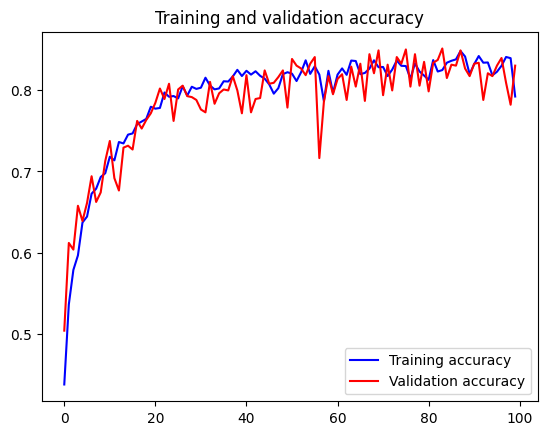

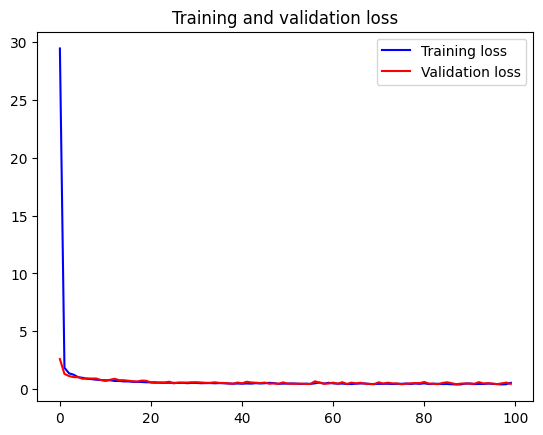

In [21]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
pred = vit.predict(val_dataset)

27/27 [==============================] - 6s 92ms/step


In [22]:
predicted=[]
labels=[]
for im, label in val_dataset:
    predicted.append(vit(im))
    labels.append(label.numpy())

In [23]:
pred= np.concatenate([np.argmax(predicted[:-1],axis=-1).flatten(),np.argmax(predicted[-1],axis=-1).flatten()])
lab= np.concatenate([np.argmax(labels[:-1],axis=-1).flatten(),np.argmax(labels[-1],axis=-1).flatten()])

Text(0.5, 58.7222222222222, 'Predicted')

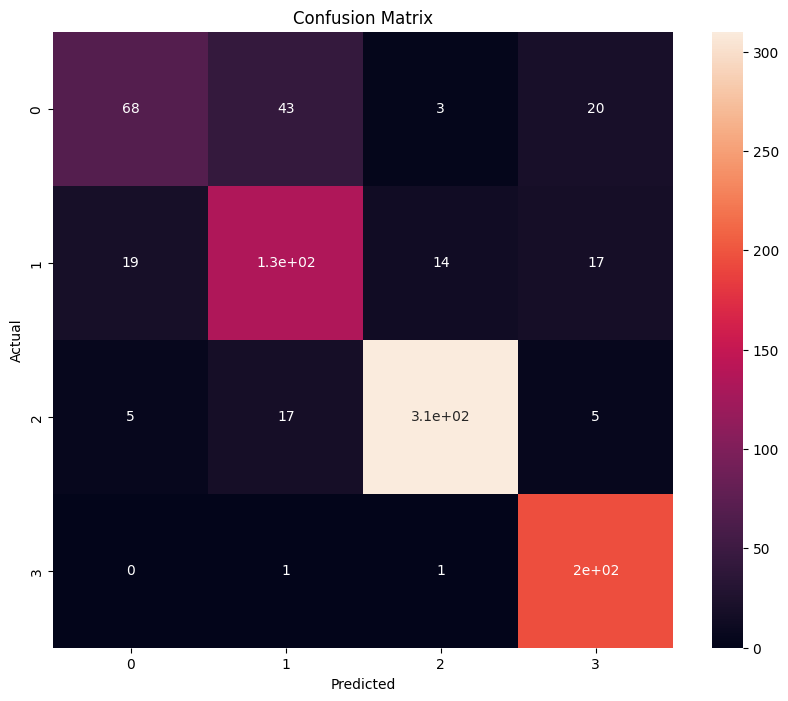

In [24]:
cm=confusion_matrix(lab,pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True)
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel("Predicted")

In [30]:
from sklearn import metrics
print('Accuracy:', np.round(metrics.accuracy_score(lab,pred),3)*100,'%')
print('Precision:', np.round(metrics.precision_score(lab,pred, average='weighted'),5))
print('Recall:', np.round(metrics.recall_score(lab,pred, average='weighted'),5))
#print('F1 Score:', np.round(metrics.f1_score(y_true, y_pred, average='weighted'),5))
print('F1 Score:', np.round(metrics.f1_score(lab,pred, average='weighted'),5))

Accuracy: 83.0 %
Precision: 0.8289
Recall: 0.83001
F1 Score: 0.82411


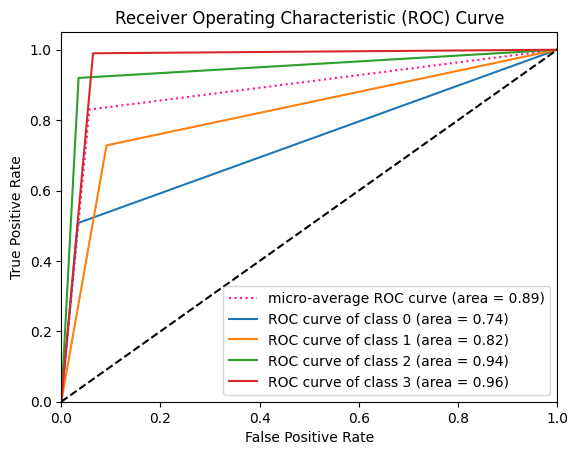

In [33]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming pred and lab are defined

n_classes = np.max(lab) + 1

# Convert pred to a matrix with shape (n_samples, n_classes)
pred_matrix = np.eye(n_classes)[pred]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((lab == i), pred_matrix[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(np.eye(n_classes)[lab].ravel(), pred_matrix.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]), color='deeppink', linestyle=':')
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


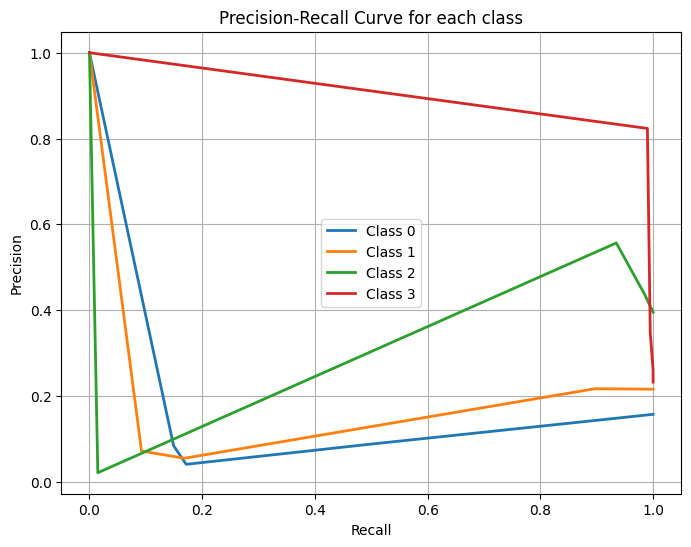

In [39]:
import numpy as np
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
n_classes = np.max(lab) + 1
precisions = dict()
recalls = dict()
thresholds = dict()
for i in range(n_classes):
    precisions[i], recalls[i], thresholds[i] = precision_recall_curve((lab == i), pred)


plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(recalls[i], precisions[i], lw=2, label=f'Class {i}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for each class')
plt.legend(loc='best')
plt.grid(True)
plt.show()
